In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.integration import lightgbm as lgb
import lightgbm as lgbm
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_feather("/home/jovyan/out/esm_prototype.feather")
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))
cloo_k, pb_k = data.cloo, data.pb

In [3]:
data

,cloo,pb,v,
0,0.615385,1.000000,2,PB
1,0.615385,1.000000,2,PB
2,0.375000,0.210526,0,neither
3,0.615385,1.000000,2,PB
4,0.615385,1.000000,2,PB
...,...,...,...,...
59044,1.000000,1.000000,3,both
59045,0.000000,1.000000,2,PB
59046,1.000000,0.545455,1,C+LOO
59047,1.000000,0.800000,1,C+LOO


In [7]:
def n_pathways(arr) -> int:
    return 5

def n_edges(arr) -> int:
    return np.abs(arr).sum()

def pathway_coverage(arr) -> float:
    return 1

def pathway_positivity(arr):
    return 1

def pathway_negativity(arr):
    return 0

def positive_pathway_coverage(arr):
    return 1

def negative_pathway_coverage(arr):
    return 0

def sparse_pathway_coverage(arr):
    return 0

def edge_coverage(arr) -> float:
    full = arr.size
    return n_edges(arr) / full

def n_pos(arr):
    return (arr == 1).sum()

def edge_positivity(arr):
    n_e = n_edges(arr)
    return n_pos(arr) / n_e if n_e != 0 else 0

def edge_negativity(arr):
    n_e = n_edges(arr)
    return (arr == -1).sum() / n_e if n_e != 0 else 0

def positive_edge_coverage(arr):
    return (arr == 1).sum() / arr.size

def negative_edge_coverage(arr):
    return (arr == -1).sum() / arr.size

def sparse_edge_coverage(arr):
    return (arr == 0).sum() / arr.size

def n_eff(arr): 
    return n_edges(arr)

def edge_effectivity(arr):
    n_e = n_edges(arr)
    return n_eff(arr) / n_e if n_e != 0 else 0

def n_effpos(arr):
    return (arr == 1).sum()

def n_effneg(arr):
    return (arr == -1).sum()


def effective_edge_positivity(arr):
    n_e = n_eff(arr)
    return n_effpos(arr) / n_e if n_e != 0 else 0


def effective_edge_negativity(arr):
    n_e = n_eff(arr)
    return n_effneg(arr) / n_e if n_e != 0 else 0

def edge_loading(arr):
    return np.array([
        0,
        (arr[(0),] != 0).sum(),
        (arr[(1, 4),] != 0).sum() + (arr[(0, 4),] != 0).all(),
        (arr[(2, 5, 7),] != 0).sum() + (arr[(1, 7),] != 0).all() + (arr[(4, 7),] != 0).all() + ((arr[(0, 5),] != 0).all() or (arr[(0, 4, 7),] != 0).all()),
        (arr[(3, 6, 8, 9),] != 0).sum() + (arr[(2, 9),] != 0).all() + (arr[(5, 9),] != 0).all() + (arr[(7, 9),] != 0).all() + \
        ((arr[(1, 8),] != 0).all() or (arr[(1, 7, 9),] != 0).all()) + ((arr[(4, 8),] != 0).all() or (arr[(4, 7, 9),] != 0).all()) + \
        ((arr[(0, 6),] != 0).all() or (arr[(0, 5, 9),] != 0).all() or (arr[(0, 4, 8),] != 0).all() or (arr[(0, 5, 9),] != 0).all() or (arr[(0, 4, 7, 9),] != 0).all())
    ])

def max_edge_density(arr):
    return edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_edge_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return edge_loading(arr).sum() / theoretical if theoretical != 0 else 0

def positive_edge_loading(arr):
    return np.array([
        0,
        (arr[(0),] == 1).sum(),
        (arr[(1, 4),] == 1).sum() + (arr[(0, 4),] == 1).all(),
        (arr[(2, 5, 7),] == 1).sum() + (arr[(1, 7),] == 1).all() + (arr[(4, 7),] == 1).all() + ((arr[(0, 5),] == 1).all() or (arr[(0, 4, 7),] == 1).all()),
        (arr[(3, 6, 8, 9),] == 1).sum() + (arr[(2, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + (arr[(7, 9),] == 1).all() + \
        ((arr[(1, 8),] == 1).all() or (arr[(1, 7, 9),] == 1).all()) + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()) + \
        ((arr[(0, 6),] == 1).all() or (arr[(0, 5, 9),] == 1).all() or (arr[(0, 4, 8),] == 1).all() or (arr[(0, 5, 9),] == 1).all() or (arr[(0, 4, 7, 9),] == 1).all())
    ])


def max_positive_edge_density(arr):
    return positive_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0


def mean_positive_edge_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return positive_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def synergetic_edge_loading(arr):
    return positive_edge_loading(arr)

def max_synergetic_edge_density(arr):
    return synergetic_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_synergetic_edge_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return synergetic_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def factor_loading(arr):
    return np.array([
        1,
        1 + (arr[(0),] != 0).sum(),
        1 + (arr[(4),] != 0).sum() + ((arr[(0, 4),] != 0).all() or (arr[(1),] != 0).all()),
        1 + (arr[(7),] != 0).sum() + ((arr[(4, 7),] != 0).all() or (arr[(5),] != 0).all()) + \
        ((arr[(0, 4, 7),] != 0).all() or (arr[(0, 5),] != 0).all() or (arr[(1, 7),] != 0).all() or (arr[(2),] != 0).all()),
        1 + (arr[(9),] != 0).sum() + ((arr[(7, 9),] != 0).all() or (arr[(8),] != 0).all()) + \
        ((arr[(4, 7, 9),] != 0).all() or (arr[(4, 8),] != 0).all() or (arr[(5, 9),] != 0).all() or (arr[(6),] != 0).all()) + \
        ((arr[(0, 4, 7, 9),] != 0).all() or (arr[(0, 4, 8),] != 0).all() or (arr[(0, 5, 9),] != 0).all() or (arr[(0, 6),] != 0).all() or \
         (arr[(1, 7, 9),] != 0).all() or (arr[(1, 8),] != 0).all() or (arr[(2, 9),] != 0).all() or (arr[(3),] != 0).all()),
    ])

def max_factor_density(arr):
    return factor_loading(arr).max() / 5

def mean_factor_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) / 2
    return factor_loading(arr).sum() / theoretical


def positive_factor_loading(arr):
    return np.array([
        1,
        1 + (arr[(0),] == 1).sum(),
        1 + (arr[(4),] == 1).sum() + ((arr[(0, 4),] == 1).all() or (arr[(1),] == 1).all()),
        1 + (arr[(7),] == 1).sum() + ((arr[(4, 7),] == 1).all() or (arr[(5),] == 1).all()) + \
        ((arr[(0, 4, 7),] == 1).all() or (arr[(0, 5),] == 1).all() or (arr[(1, 7),] == 1).all() or (arr[(2),] == 1).all()),
        1 + (arr[(9),] == 1).sum() + ((arr[(7, 9),] == 1).all() or (arr[(8),] == 1).all()) + \
        ((arr[(4, 7, 9),] == 1).all() or (arr[(4, 8),] == 1).all() or (arr[(5, 9),] == 1).all() or (arr[(6),] == 1).all()) + \
        ((arr[(0, 4, 7, 9),] == 1).all() or (arr[(0, 4, 8),] == 1).all() or (arr[(0, 5, 9),] == 1).all() or (arr[(0, 6),] == 1).all() or \
         (arr[(1, 7, 9),] == 1).all() or (arr[(1, 8),] == 1).all() or (arr[(2, 9),] == 1).all() or (arr[(3),] == 1).all()),
    ])

def max_positive_factor_density(arr):
    return positive_factor_loading(arr).max() / 5


def mean_positive_factor_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) / 2
    return positive_factor_loading(arr).sum() / theoretical


def synergetic_factor_loading(arr):
    return positive_factor_loading(arr)

def max_synergetic_factor_density(arr):
    return synergetic_factor_loading(arr).max() / 5


def mean_synergetic_factor_density(arr):
    n_factor = 5
    theoretical = n_factor * (n_factor + 1) / 2
    return synergetic_factor_loading(arr).sum() / theoretical


def cascade_length(arr):
    return np.array([
        1,
        1 + np.max([0, (arr[(0),] != 0).sum()]),
        1 + np.max([
            0, (arr[(1),] != 0).sum(), (arr[(4),] != 0).sum(), 
            (arr[(0, 4),] != 0).sum() * (arr[(0, 4),] != 0).all()
        ]),
        1 + np.max([
            0, (arr[(2),] != 0).sum(), (arr[(5),] != 0).sum(), (arr[(7),] != 0).sum(), 
            (arr[(0, 5),] != 0).sum() * (arr[(0, 5),] != 0).all(), 
            (arr[(1, 7),] != 0).sum() * (arr[(1, 7),] != 0).all(),
            (arr[(4, 7),] != 0).sum() * (arr[(4, 7),] != 0).all(),
            (arr[(0, 4, 7),] != 0).sum() * (arr[(0, 4, 7),] != 0).all()
        ]),
        1 + np.max([
            0 + (arr[(3),] != 0).sum(), (arr[(6),] != 0).sum(), (arr[(8),] != 0).sum(), (arr[(9),] != 0).sum(), 
            (arr[(0, 6),] != 0).sum() * (arr[(0, 6),] != 0).all(),
            (arr[(1, 8),] != 0).sum() * (arr[(1, 8),] != 0).all(),
            (arr[(2, 9),] != 0).sum() * (arr[(2, 9),] != 0).all(),
            (arr[(4, 8),] != 0).sum() * (arr[(4, 8),] != 0).all(),
            (arr[(5, 9),] != 0).sum() * (arr[(5, 9),] != 0).all(),
            (arr[(0, 4, 8),] != 0).sum() * (arr[(0, 4, 8),] != 0).all(),
            (arr[(0, 5, 9),] != 0).sum() * (arr[(0, 5, 9),] != 0).all(),
            (arr[(1, 7, 9),] != 0).sum() * (arr[(1, 7, 9),] != 0).all(),
            (arr[(4, 7, 9),] != 0).sum() * (arr[(4, 7, 9),] != 0).all(),
            (arr[(0, 4, 7, 9),] != 0).sum() * (arr[(0, 4, 7, 9),] != 0).all(),
        ])
    ])

def max_cascade_length_ratio(arr):
    return cascade_length(arr).max() / 5

def mean_cascade_length_ratio(arr):
    n_factor = 5
    theoretical = (1 + n_factor) * n_factor / 2
    return cascade_length(arr).sum() / theoretical

def positive_cascade_length(arr):
    return np.array([
        1,
        1 + np.max([0, (arr[(0),] == 1).sum()]),
        1 + np.max([
            0, (arr[(1),] == 1).sum(), (arr[(4),] == 1).sum(), 
            (arr[(0, 4),] == 1).sum() * (arr[(0, 4),] == 1).all()
        ]),
        1 + np.max([
            0, (arr[(2),] == 1).sum(), (arr[(5),] == 1).sum(), (arr[(7),] == 1).sum(), 
            (arr[(0, 5),] == 1).sum() * (arr[(0, 5),] == 1).all(), 
            (arr[(1, 7),] == 1).sum() * (arr[(1, 7),] == 1).all(),
            (arr[(4, 7),] == 1).sum() * (arr[(4, 7),] == 1).all(),
            (arr[(0, 4, 7),] == 1).sum() * (arr[(0, 4, 7),] == 1).all()
        ]),
        1 + np.max([
            0 + (arr[(3),] == 1).sum(), (arr[(6),] == 1).sum(), (arr[(8),] == 1).sum(), (arr[(9),] == 1).sum(), 
            (arr[(0, 6),] == 1).sum() * (arr[(0, 6),] == 1).all(),
            (arr[(1, 8),] == 1).sum() * (arr[(1, 8),] == 1).all(),
            (arr[(2, 9),] == 1).sum() * (arr[(2, 9),] == 1).all(),
            (arr[(4, 8),] == 1).sum() * (arr[(4, 8),] == 1).all(),
            (arr[(5, 9),] == 1).sum() * (arr[(5, 9),] == 1).all(),
            (arr[(0, 4, 8),] == 1).sum() * (arr[(0, 4, 8),] == 1).all(),
            (arr[(0, 5, 9),] == 1).sum() * (arr[(0, 5, 9),] == 1).all(),
            (arr[(1, 7, 9),] == 1).sum() * (arr[(1, 7, 9),] == 1).all(),
            (arr[(4, 7, 9),] == 1).sum() * (arr[(4, 7, 9),] == 1).all(),
            (arr[(0, 4, 7, 9),] == 1).sum() * (arr[(0, 4, 7, 9),] == 1).all(),
        ])
    ])

def max_positive_cascade_length_ratio(arr):
    return positive_cascade_length(arr).max() / 5

def mean_positive_cascade_length_ratio(arr):
    n_factor = 5
    theoretical = (1 + n_factor) * n_factor / 2
    return positive_cascade_length(arr).sum() / theoretical

def synergetic_cascade_length(arr):
    return positive_cascade_length(arr)

def max_synergetic_cascade_length_ratio(arr):
    return synergetic_cascade_length(arr).max() / 5

def mean_synergetic_cascade_length_ratio(arr):
    n_factor = 5
    theoretical = (1 + n_factor) * n_factor / 2
    return synergetic_cascade_length(arr).sum() / theoretical

In [8]:
df = pd.DataFrame(dict(
    pathway_coverage=list(map(pathway_coverage, edges)),
    pathway_positivity=list(map(pathway_positivity, edges)),
    pathway_negativity=list(map(pathway_negativity, edges)),
    positive_pathway_coverage=list(map(positive_pathway_coverage, edges)),
    negative_pathway_coverage=list(map(negative_pathway_coverage, edges)),
    sparse_pathway_coverage=list(map(sparse_pathway_coverage, edges)),
    edge_coverage=list(map(edge_coverage, edges)),
    edge_positivity=list(map(edge_positivity, edges)),
    edge_negativity=list(map(edge_negativity, edges)),
    positive_edge_coverage=list(map(positive_edge_coverage, edges)),
    negative_edge_coverage=list(map(negative_edge_coverage, edges)),
    sparse_edge_coverage=list(map(sparse_edge_coverage, edges)),
    edge_effectivity=list(map(edge_effectivity, edges)),
    effective_edge_positivity=list(map(effective_edge_positivity, edges)),
    effective_edge_negativity=list(map(effective_edge_negativity, edges)),
    max_edge_density=list(map(max_edge_density, edges)),
    mean_edge_density=list(map(mean_edge_density, edges)),
    max_positive_edge_density=list(map(max_positive_edge_density, edges)),
    mean_positive_edge_density=list(map(mean_positive_edge_density, edges)),
    max_synergetic_edge_density=list(map(max_synergetic_edge_density, edges)),
    mean_synergetic_edge_density=list(map(mean_synergetic_edge_density, edges)),
    max_factor_density=list(map(max_factor_density, edges)),
    mean_factor_density=list(map(mean_factor_density, edges)),
    max_positive_factor_density=list(map(max_positive_factor_density, edges)),
    mean_positive_factor_density=list(map(mean_positive_factor_density, edges)),
    max_synergetic_factor_density=list(map(max_synergetic_factor_density, edges)),
    mean_synergetic_factor_density=list(map(mean_synergetic_factor_density, edges)),
    max_cascade_length_ratio=list(map(max_cascade_length_ratio, edges)),
    mean_cascade_length_ratio=list(map(mean_cascade_length_ratio, edges)),
    max_positive_cascade_length_ratio=list(map(max_positive_cascade_length_ratio, edges)),
    mean_positive_cascade_length_ratio=list(map(mean_positive_cascade_length_ratio, edges)),
    max_synergetic_cascade_length_ratio=list(map(max_synergetic_cascade_length_ratio, edges)),
    mean_synergetic_cascade_length_ratio=list(map(mean_synergetic_cascade_length_ratio, edges)),
    # cai=list(map(cai, edges)),
    # ecai=list(map(ecai, edges)),
    # wcai=list(map(wcai, edges)),
    # wecai=list(map(wecai, edges)),
))

In [9]:
df.max(axis=0)

pathway_coverage                        1.0
pathway_positivity                      1.0
pathway_negativity                      0.0
positive_pathway_coverage               1.0
negative_pathway_coverage               0.0
sparse_pathway_coverage                 0.0
edge_coverage                           1.0
edge_positivity                         1.0
edge_negativity                         1.0
positive_edge_coverage                  1.0
negative_edge_coverage                  1.0
sparse_edge_coverage                    1.0
edge_effectivity                        1.0
effective_edge_positivity               1.0
effective_edge_negativity               1.0
max_edge_density                        1.0
mean_edge_density                       1.0
max_positive_edge_density               1.0
mean_positive_edge_density              1.0
max_synergetic_edge_density             1.0
mean_synergetic_edge_density            1.0
max_factor_density                      1.0
mean_factor_density             

In [10]:
df.corr()

,pathway_coverage,pathway_positivity,pathway_negativity,positive_pathway_coverage,negative_pathway_coverage,sparse_pathway_coverage,edge_coverage,edge_positivity,edge_negativity,positive_edge_coverage,...,max_positive_factor_density,mean_positive_factor_density,max_synergetic_factor_density,mean_synergetic_factor_density,max_cascade_length_ratio,mean_cascade_length_ratio,max_positive_cascade_length_ratio,mean_positive_cascade_length_ratio,max_synergetic_cascade_length_ratio,mean_synergetic_cascade_length_ratio
pathway_coverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pathway_positivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pathway_negativity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
positive_pathway_coverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_pathway_coverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sparse_pathway_coverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
edge_coverage,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000190,0.000190,0.500000,...,0.396683,0.452289,0.396683,0.452289,0.639019,0.648873,0.350727,0.388959,0.350727,0.388959
edge_positivity,NaN,NaN,NaN,NaN,NaN,NaN,0.000190,1.000000,-0.999788,0.839427,...,0.683049,0.761651,0.683049,0.761651,0.000155,0.000127,0.593331,0.652230,0.593331,0.652230
edge_negativity,NaN,NaN,NaN,NaN,NaN,NaN,0.000190,-0.999788,1.000000,-0.839237,...,-0.682855,-0.761491,-0.682855,-0.761491,0.000155,0.000127,-0.593142,-0.652086,-0.593142,-0.652086
positive_edge_coverage,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.839427,-0.839237,1.000000,...,0.793366,0.904579,0.793366,0.904579,0.319510,0.324437,0.701453,0.777917,0.701453,0.777917


from sklearn.manifold import TSNE

tsne = TSNE(random_state=0).fit_transform(df)

df_tsne = pd.DataFrame(tsne, columns=["x", "y"])

sns.scatterplot(
    data=df_tsne,
    x="x", y="y", hue=data.loc[:, ""]
)

In [11]:
x_tr, x_te, y_tr, y_te = train_test_split(
    df, 
    data.loc[:, "v"],
    # data.cloo,
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)


params = dict(
    objective="multiclass", 
    metric="multi_logloss",
    num_class=data.v.unique().size,
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

# params = dict(
#     objective="regression",
#     metric="l2",
#     verbosity=-1,
#     deterministic=True,
#     random_seed=0, 
#     num_boost_round=100,
#     force_col_wise=True
# )

In [12]:
logger = {}

model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    # verbosity=-1,
    callbacks=[
        lgbm.early_stopping(100), 
        lgbm.log_evaluation(10000), 
        lgbm.record_evaluation(logger)
    ]
)

[I 2024-12-03 14:33:07,523] A new study created in memory with name: no-name-a1345b65-5029-43e8-89c1-b7a6b0fc16c4


In [13]:
%%capture
model.run()

[I 2024-12-03 14:33:09,149] Trial 0 finished with value: 1.0706473867233495 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.0706473867233495.
[I 2024-12-03 14:33:09,946] Trial 1 finished with value: 1.0707794470051692 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 1.0706473867233495.
[I 2024-12-03 14:33:10,864] Trial 2 finished with value: 1.0718771687965116 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.0706473867233495.
[I 2024-12-03 14:33:11,715] Trial 3 finished with value: 1.0705262515766705 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 1.0705262515766705.
[I 2024-12-03 14:33:12,499] Trial 4 finished with value: 1.0735496080260702 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 1.0705262515766705.
[I 2024-12-03 14:33:13,421] Trial 5 finished with value: 1.0703087504591933 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 1.0

In [14]:
tuned = model.get_best_booster()

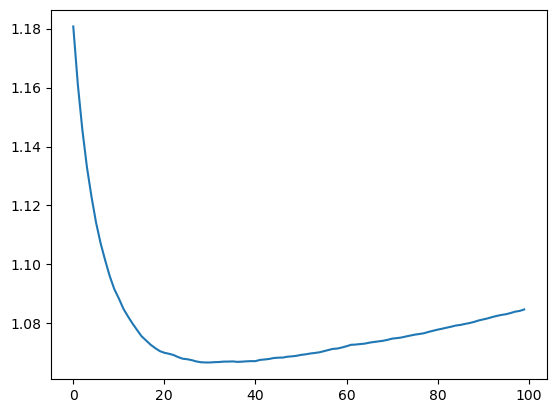

In [15]:
plt.plot(logger["valid_0"]["multi_logloss"])

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

In [17]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [18]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AUC:{auc.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(roc.auc) - 1)) if isinstance(cmap, str) else cmap[i]
        )
    
    ax[-1].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c=".2",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(2)})"
    )
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax]
    ax[-1].set(title="ROC curve")
    [sp.legend(fontsize="small") for sp in ax]

In [19]:
class pr_multi():
    def __init__(self, model, x, y):
        self.x = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.y = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.thresh = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.ap = [
            average_precision_score(y[:, i], model.predict(x)[:, i]) for i in range(y.shape[1])
        ]
        self.base = [len(y[:, i][y[:, i] == 1]) / len(y) for i in range(y.shape[1])]

In [20]:
def plot_pr(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    pr = pr_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, ap, label, base in zip(enumerate(pr.x), pr.y, pr.ap, label_dict, pr.base):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AP:{ap.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(roc.auc) - 1)) if isinstance(cmap, str) else cmap[i]
        )
        ax[i].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    
    p_avg, r_avg, thr_avg = precision_recall_curve(y.ravel(), model.predict(x).ravel())
    
    ax[-1].plot(
        r_avg, p_avg, 
        c=".2", 
        label=f"micro (AP:{average_precision_score(y, model.predict(x)).round(2)})"
    )
    base = np.array(pr.base).mean()
    ax[-1].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 1], [1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=2) for sp in ax]
    [sp.set(xlabel="recall", ylabel="precision", title="PR curve (OvR)") for sp in ax] 
    ax[-1].set(title="PR curve")
    [sp.legend(fontsize="small") for sp in ax]

In [21]:
testx = x_te.loc[y_te.sort_values().index, :]
testy = y_te.sort_values()

In [22]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

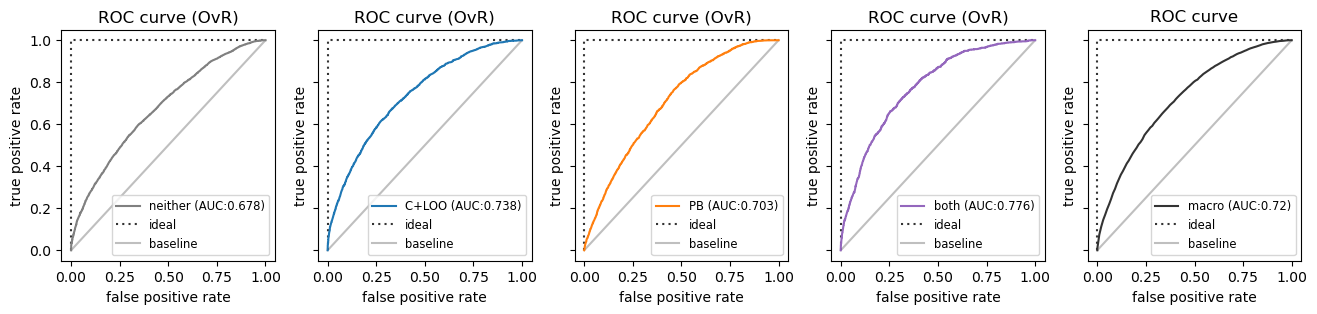

In [23]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_roc(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

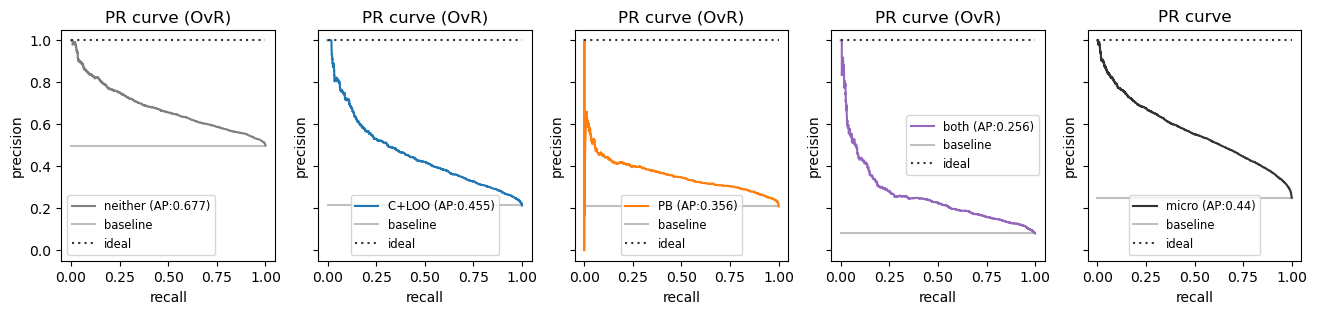

In [24]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_pr(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

In [25]:
from sklearn.metrics import confusion_matrix

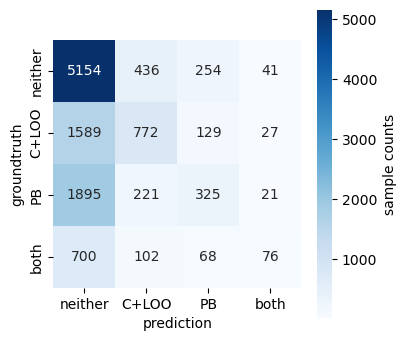

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(testy, tuned.predict(testx).argmax(axis=1)), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts"}
)

ax.set_xticklabels(["neither", "C+LOO", "PB", "both"])
ax.set_yticklabels(["neither", "C+LOO", "PB", "both"])
ax.set(xlabel="prediction", ylabel="groundtruth");

In [27]:
shap.initjs()

In [28]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

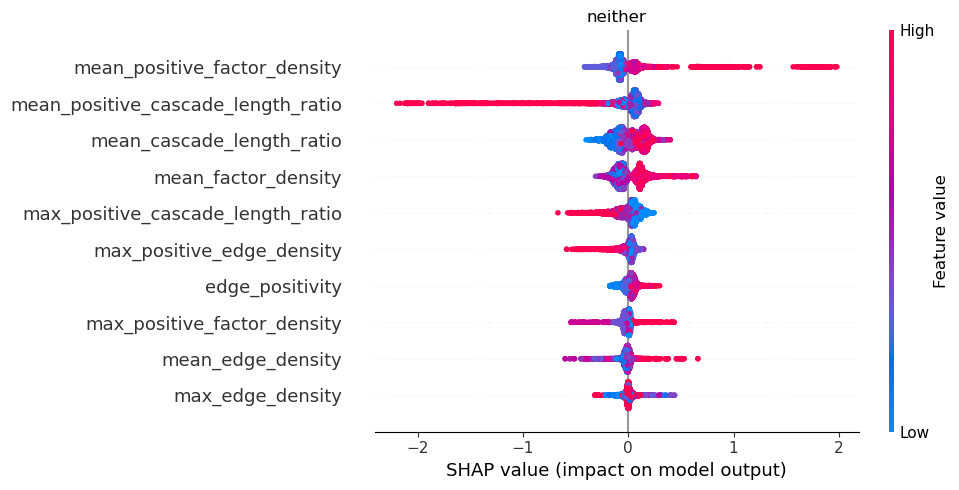

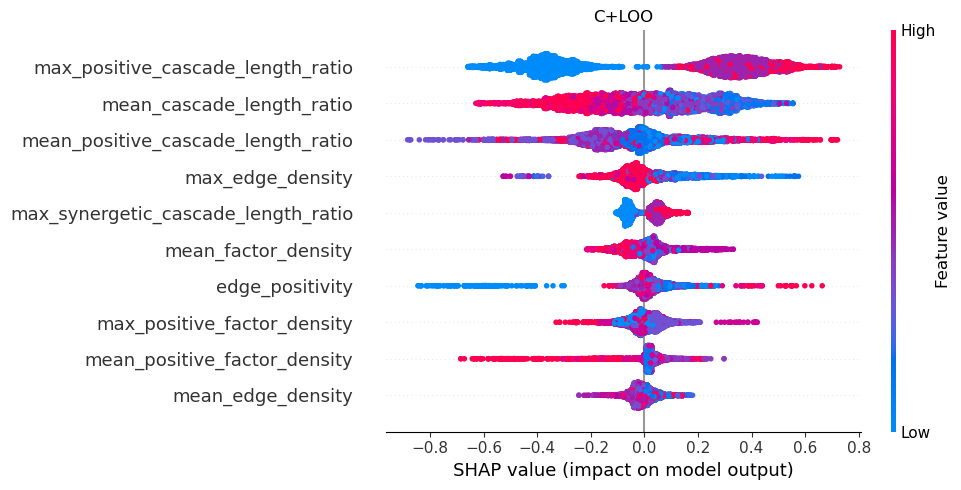

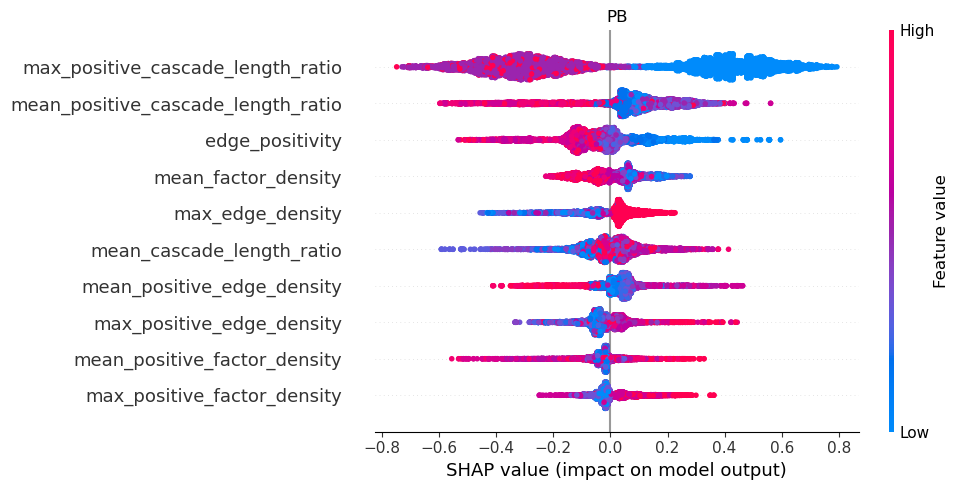

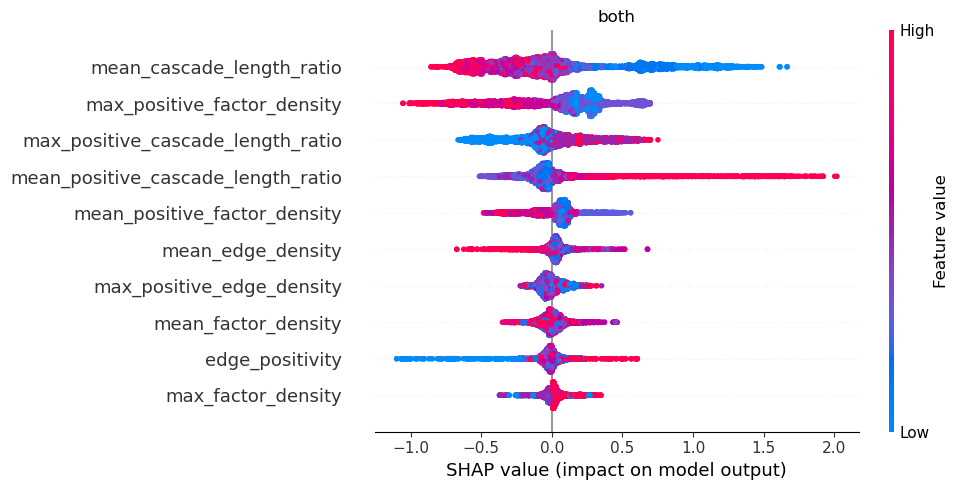

In [29]:
for i in testy.unique():
    plt.axes(title={i: k for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}[i])
    shap.summary_plot(
        shap_values[:, :, i], testx, 
        # max_display=df.shape[1], 
        max_display=10,
        show=True,
        plot_size=(10, 5)
    )

In [520]:
df9 = pd.DataFrame(dict(
    pathway_coverage=[5/9, 4/9, 2/9, ],
    pathway_positivity=[4/5, 3/4, 1/2, ],
    pathway_negativity=[1/5, 1/4, 1/2, ],
    positive_pathway_coverage=[4/9, 3/9, 1/9, ],
    negative_pathway_coverage=[1/9, 1/4, 1/9, ],
    sparse_pathway_coverage=[4/9, 5/9, 7/9, ],
    edge_coverage=[6/36, 12/36, 7/36, ],
    edge_positivity=[3/6, 7/12, 4/7, ],
    edge_negativity=[3/6, 5/12, 3/7, ],
    positive_edge_coverage=[3/36, 7/36, 4/36, ],
    negative_edge_coverage=[3/36, 5/36, 3/36, ],
    sparse_edge_coverage=[30/36, 24/36, 29/36, ],
    edge_effectivity=[6/6, 11/12, 0/7, ],
    effective_edge_positivity=[3/6, 6/11, 0, ],
    effective_edge_negativity=[3/6, 5/11, 0, ],
    max_edge_density=[5/6, 10/11, 0, ],
    mean_edge_density=[(1+5+1)/(9*6), (10+11)/(9*11), 0, ],
    max_factor_density=[6/9, 6/9, 1/9, ],
    mean_factor_density=[(1+1+1+6+2)/(9*9), (1+1+5+6)/(9*9), (1+1)/(9*9)],
    max_cascade_length_ratio=[3/9, 6/9, 1/9, ],
    mean_cascade_length_ratio=[(1+1+1+3+2)/45, (1+1+5+6)/45, (1+1)/45, ],
    max_positive_cascade_length_ratio=[2/9, 5/9, 1/9],
    mean_positive_cascade_length_ratio=[(1+1+1+2)/45, (1+5+1)/45, (1)/45, ],
    max_synergetic_cascade_length_ratio=[2/9, 5/9, 1/9, ],
    mean_synergetic_cascade_length_ratio=[(1+1+1+2+2)/45, (1+1+5+1)/45, (1+1)/45, ],
    # cai=[np.mean([6/36, 3/6]), np.mean([12/36, 7/12]), np.mean([7/36, 4/7]),],
    # ecai=[np.mean([6/36, 3/6]), np.mean([11/36, 6/11]), np.mean([0/36, 0]),],
    # wcai=[np.mean([6/36, 3/6, (1+5+1)/(9*6)]), np.mean([12/36, 7/12, (10+11)/(9*11)]), np.mean([7/36, 4/7, 0]), ],
    # wecai=[np.mean([6/36, 3/6, (1+5+1)/(9*6)]), np.mean([11/36, 6/11, (10+11)/(9*11)]), np.mean([0/36, 0, 0]), ], 
))

In [521]:
tuned.predict(df9)

array([[0.01100353, 0.02952876, 0.9561488 , 0.00331891],
       [0.25099157, 0.1034319 , 0.63017613, 0.0154004 ],
       [0.01602793, 0.25946457, 0.04365106, 0.68085644]])

# Regression

x_tr, x_te, y_tr, y_te = train_test_split(
    df, 
    # data.loc[:, "v"],
    data.cloo,
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)


params = dict(
    objective="regression",
    metric="l2",
    verbosity=-1,
    deterministic=True,
    random_seed=0, 
    num_boost_round=100,
    force_col_wise=True
)

logger = {}

model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    # verbosity=-1,
    callbacks=[
        lgbm.early_stopping(100), 
        lgbm.log_evaluation(1000), 
        lgbm.record_evaluation(logger)
    ]
)

%%capture
model.run()

tuned = model.get_best_booster()

plt.plot(logger["valid_0"]["l2"])

from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(tuned.predict(x_te), y_te)

mean_absolute_error(tuned.predict(x_te), y_te)

plt.scatter(y_te, tuned.predict(x_te))

In [59]:
dat = pd.concat([data, df], axis=1).assign(
    max_synergetic_edge_loading=list(map(lambda arr: synergetic_edge_loading(arr).max(), edges))
).assign(
    max_cascade_length=list(map(lambda arr: cascade_length(arr).max(), edges))
).assign(
    n_effpos=list(map(n_effpos, edges)),
).assign(
    cai=(df.loc[:, "max_synergetic_edge_density"] + df.loc[:, "effective_edge_positivity"]) / 2
).assign(
    cai2=(df.loc[:, "max_synergetic_edge_density"] + 1 - df.loc[:, "mean_factor_density"]) / 2
)

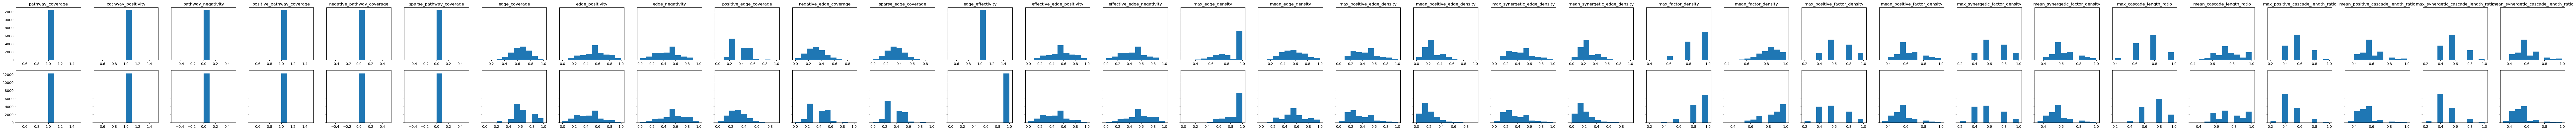

In [60]:
fig, ax = plt.subplots(2, df.columns.size, figsize=(4 * df.columns.size, 6), sharey=True)

for i, k in enumerate(df.columns):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [61]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

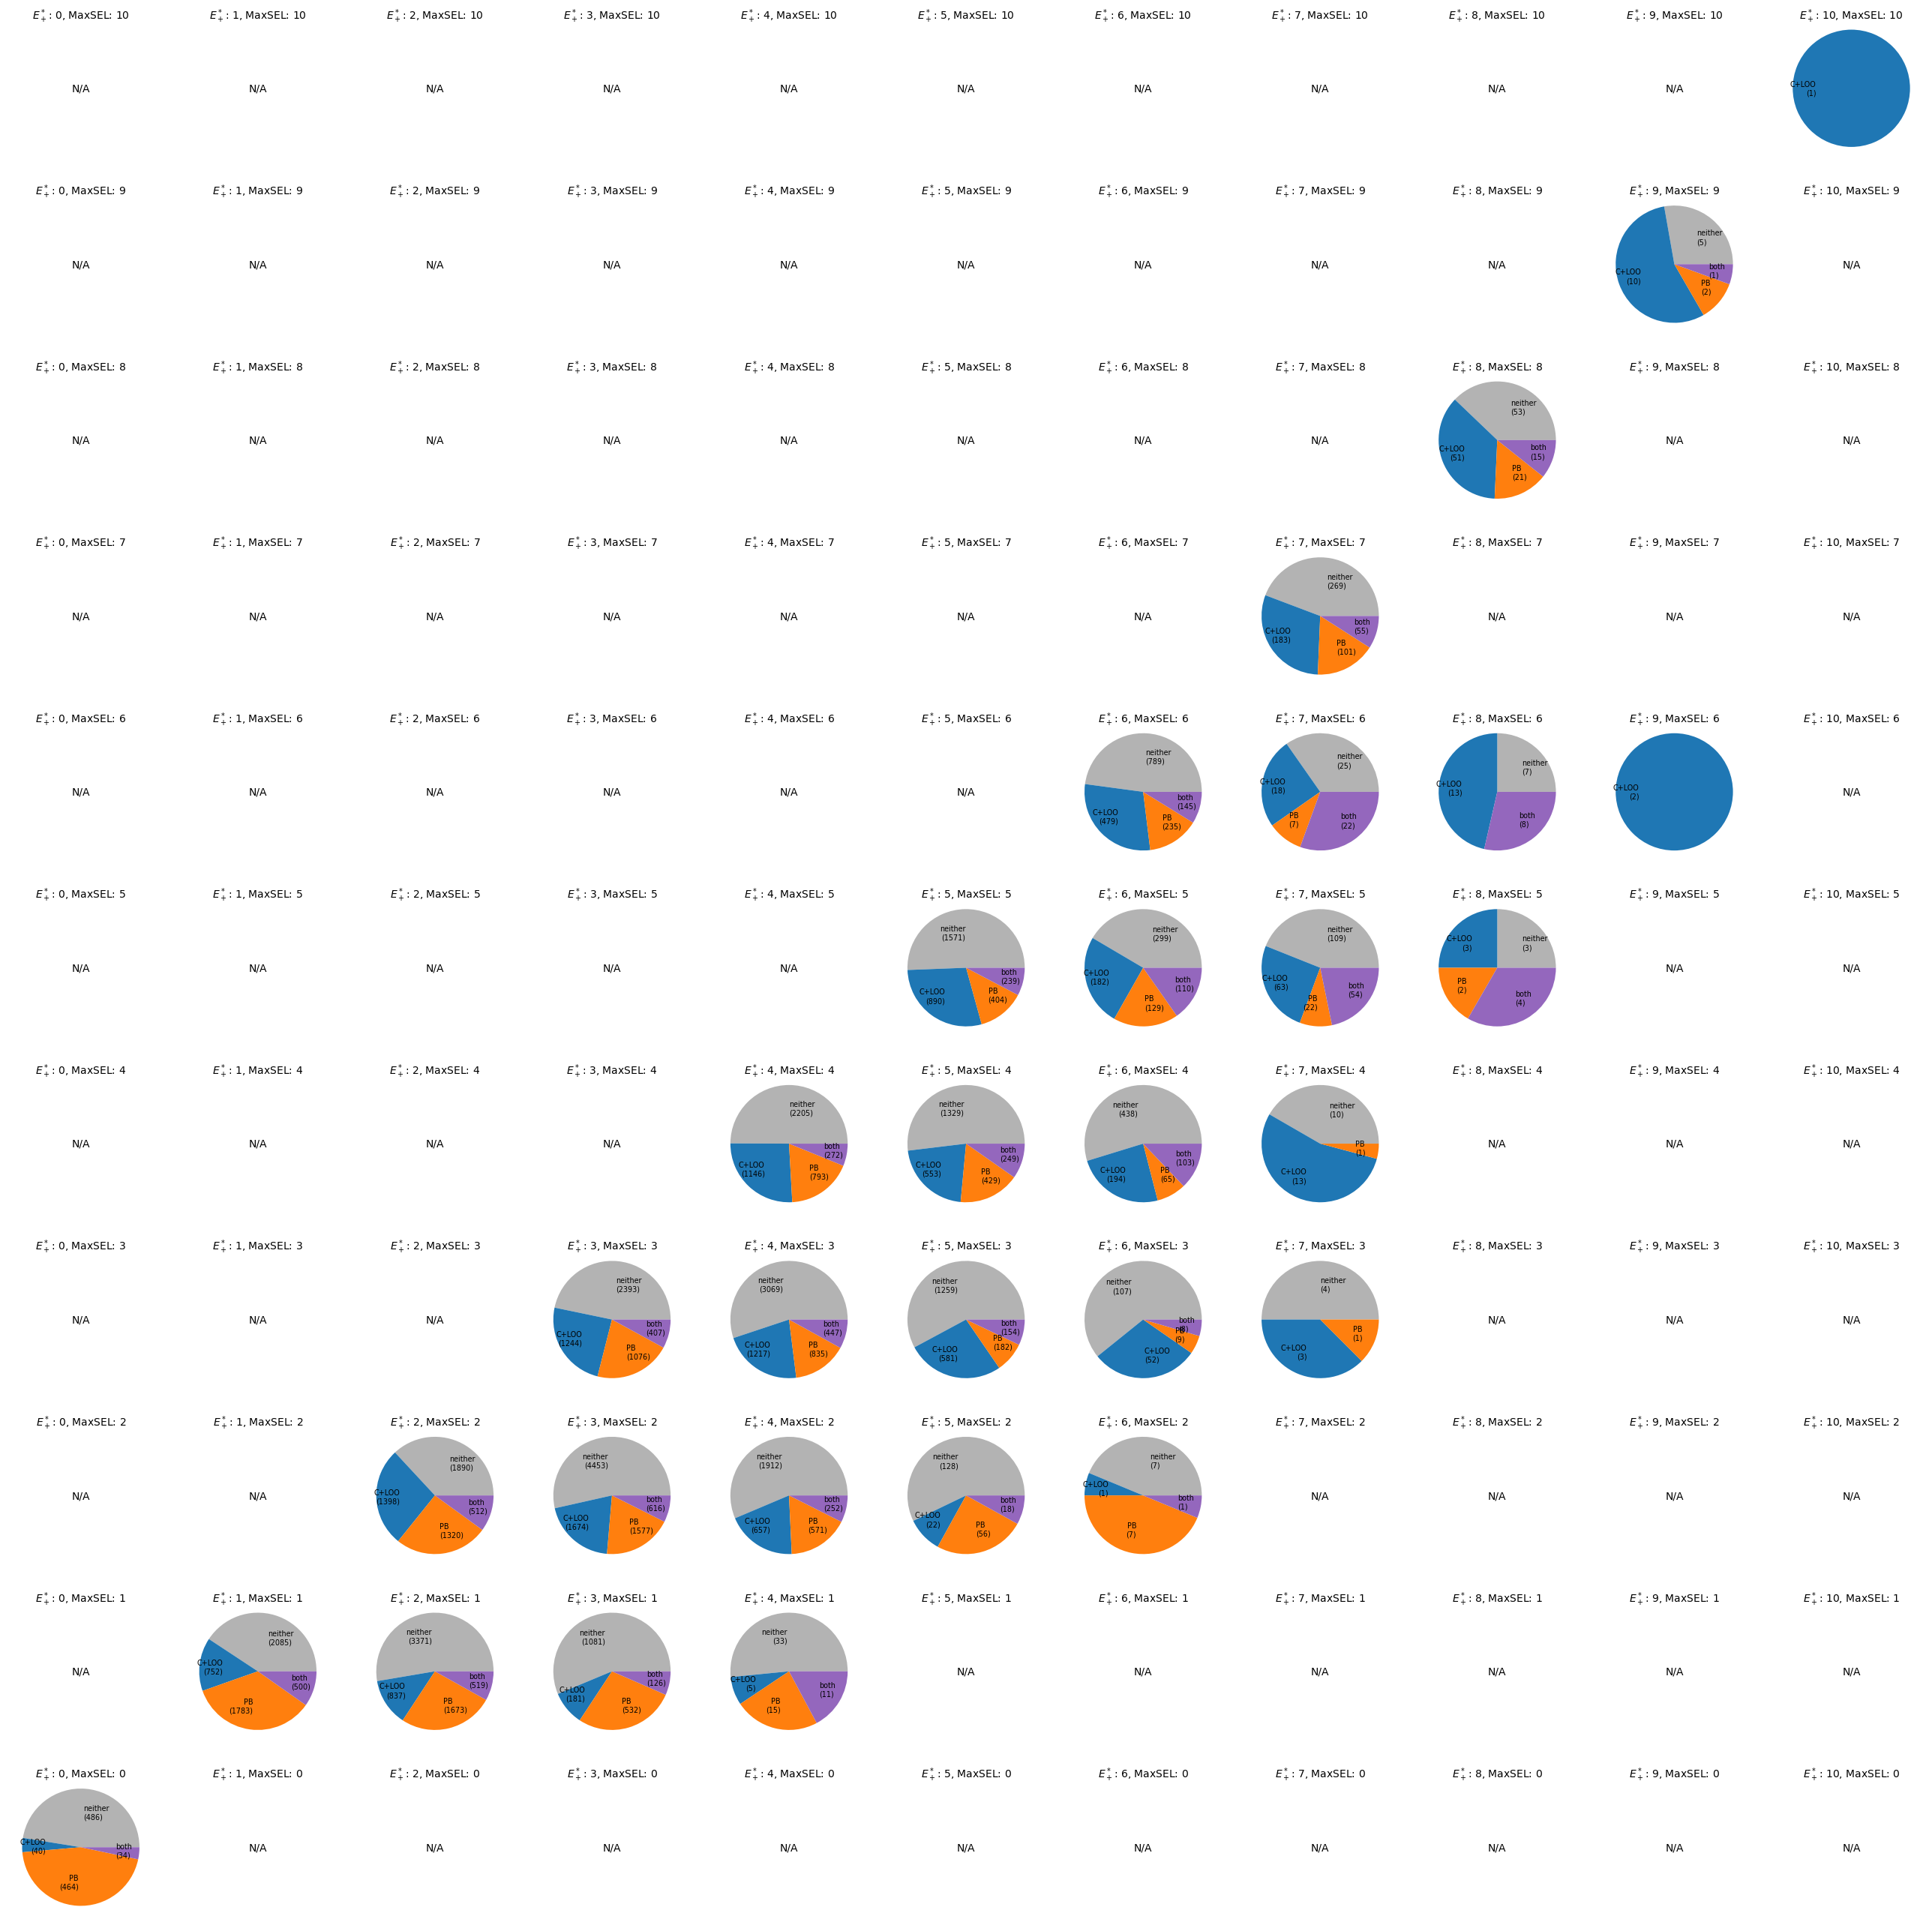

In [62]:
key_r, key_c = "max_synergetic_edge_loading", "n_effpos"
label_r, label_c = "MaxSEL", "$E_+^*$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

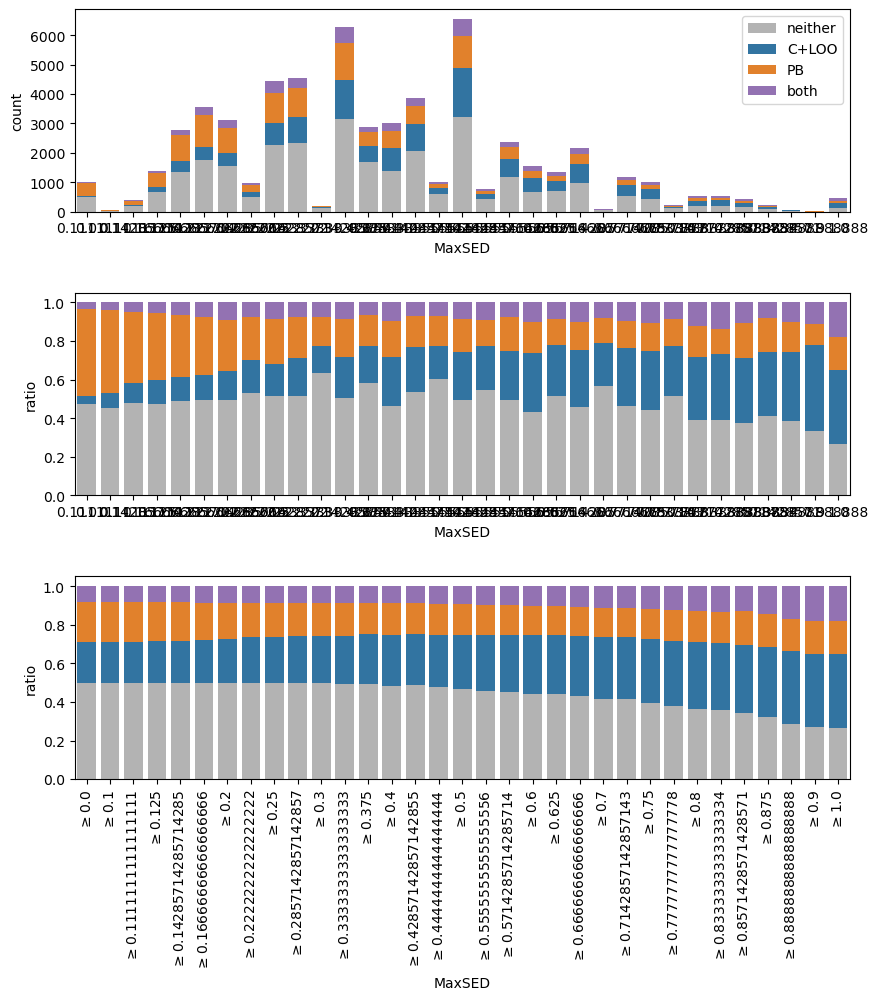

In [66]:
# key, label = "cai", "CAI"
# key, label = "cai2", "CAI2"
key, label = "max_synergetic_edge_density", "MaxSED"
# key, label = "effective_edge_positivity", r"$\frac{|E^*_+|}{|E^*|}$"
# key, label = "mean_cascade_length_ratio", "MCLR"
# key, label = "max_cascade_length_ratio", "MaxCLR"
# key, label = "mean_factor_density", "MFD"

stdf = stacked_tally(dat, key, "", stack_key="v", ratio=False)
stdf2 = stacked_tally(dat, key, "", stack_key="v", ratio=True)
stdf3 = stacked_tally(dat, key, "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.4)

for i, k in enumerate(stdf.loc[:, "index"].unique()):
    sns.barplot(
        data=stdf[stdf.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=stdf2[stdf2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=stdf3[stdf3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=label,
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

# if conf.savefig:
    # fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

[Text(0.5, 0, 'max_synergetic_edge_density'),
 Text(0, 0.5, 'class ratio (MaxSED$=x$)')]

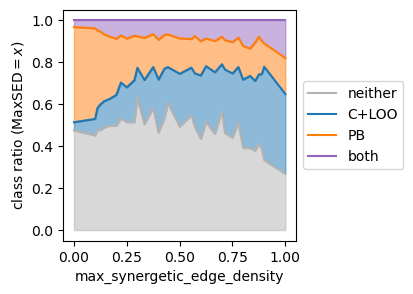

In [67]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(stdf.loc[:, "index"].unique()):
    sns.lineplot(
        data=stdf2[stdf2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel=key, ylabel=f"class ratio ({label}$=x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai{conf.suffix}", **kwarg_savefig)

[Text(0.5, 0, 'max_synergetic_edge_density'),
 Text(0, 0.5, 'class ratio (MaxSED$\\geq x$)')]

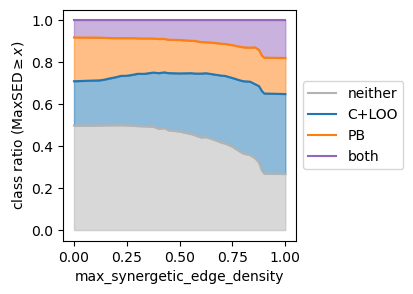

In [68]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(stdf.loc[:, "index"].unique()):
    sns.lineplot(
        data=stdf3[stdf3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel=key, ylabel=f"class ratio ({label}$\geq x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai_geq{conf.suffix}", **kwarg_savefig)

key_r, key_c = "n_edges", "load"
label_r, label_c = "$|E|$", "$load$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)